In [1]:
#importing the necessary modules
import torch
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

import cv2
from skimage import io
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Exploration

In [2]:
#reading data
#Change path to your images and csv files path 
train_data = pd.read_csv('Train .csv')
test_data = pd.read_csv('Test .csv')
train_path = 'data/train/'
test_path = 'data/test/'

In [3]:
# train
train_names = train_data.ID.values
train_labels = np.asarray(train_data['LABEL'].values)
train_dict = {'filepath': train_path + train_names + '.png', 'LABEL': train_labels}
train = pd.DataFrame(data=train_dict)
train['ID'] = train_data['ID']
#train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Normal')

# test
test_names = test_data.ID.values
test_dict = {'filepath': test_path + test_names + '.png'}
test = pd.DataFrame(data=test_dict)
test['ID'] = test_data['ID']


In [4]:
train.head()

,filepath,LABEL,ID
0,data/train/VTYNBFTO.png,1,VTYNBFTO
1,data/train/GVVXXDOZ.png,0,GVVXXDOZ
2,data/train/PMRSQLXN.png,0,PMRSQLXN
3,data/train/JXISWDUU.png,1,JXISWDUU
4,data/train/JVWMAACC.png,1,JVWMAACC


In [5]:
test.head()

,filepath,ID
0,data/test/GTWSHFYQ.png,GTWSHFYQ
1,data/test/QTFSSMGD.png,QTFSSMGD
2,data/test/TBLBHSYT.png,TBLBHSYT
3,data/test/ZKETEOFG.png,ZKETEOFG
4,data/test/GKTPBGZP.png,GKTPBGZP


In [6]:
print("Train data shape is ",train.shape)
print("Test data  shape is ",test.shape)

Train data shape is  (718, 3)
Test data  shape is  (82, 2)


/home/gerald/anaconda3/envs/tb_zindi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


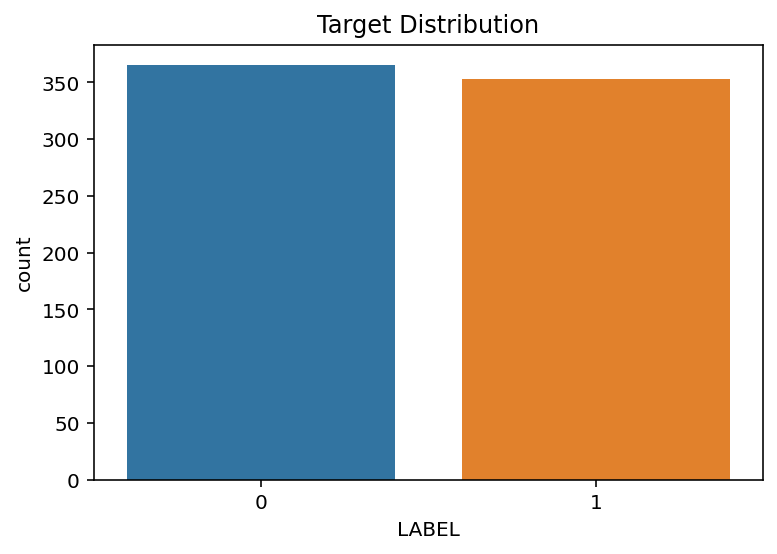

In [7]:
## EDA & PREPROCESSING
sns.countplot(train['LABEL'],order = train['LABEL'].value_counts().index)
plt.title("Target Distribution")
plt.show()

### Observation
* Our target column seems to be well balanced in the data set

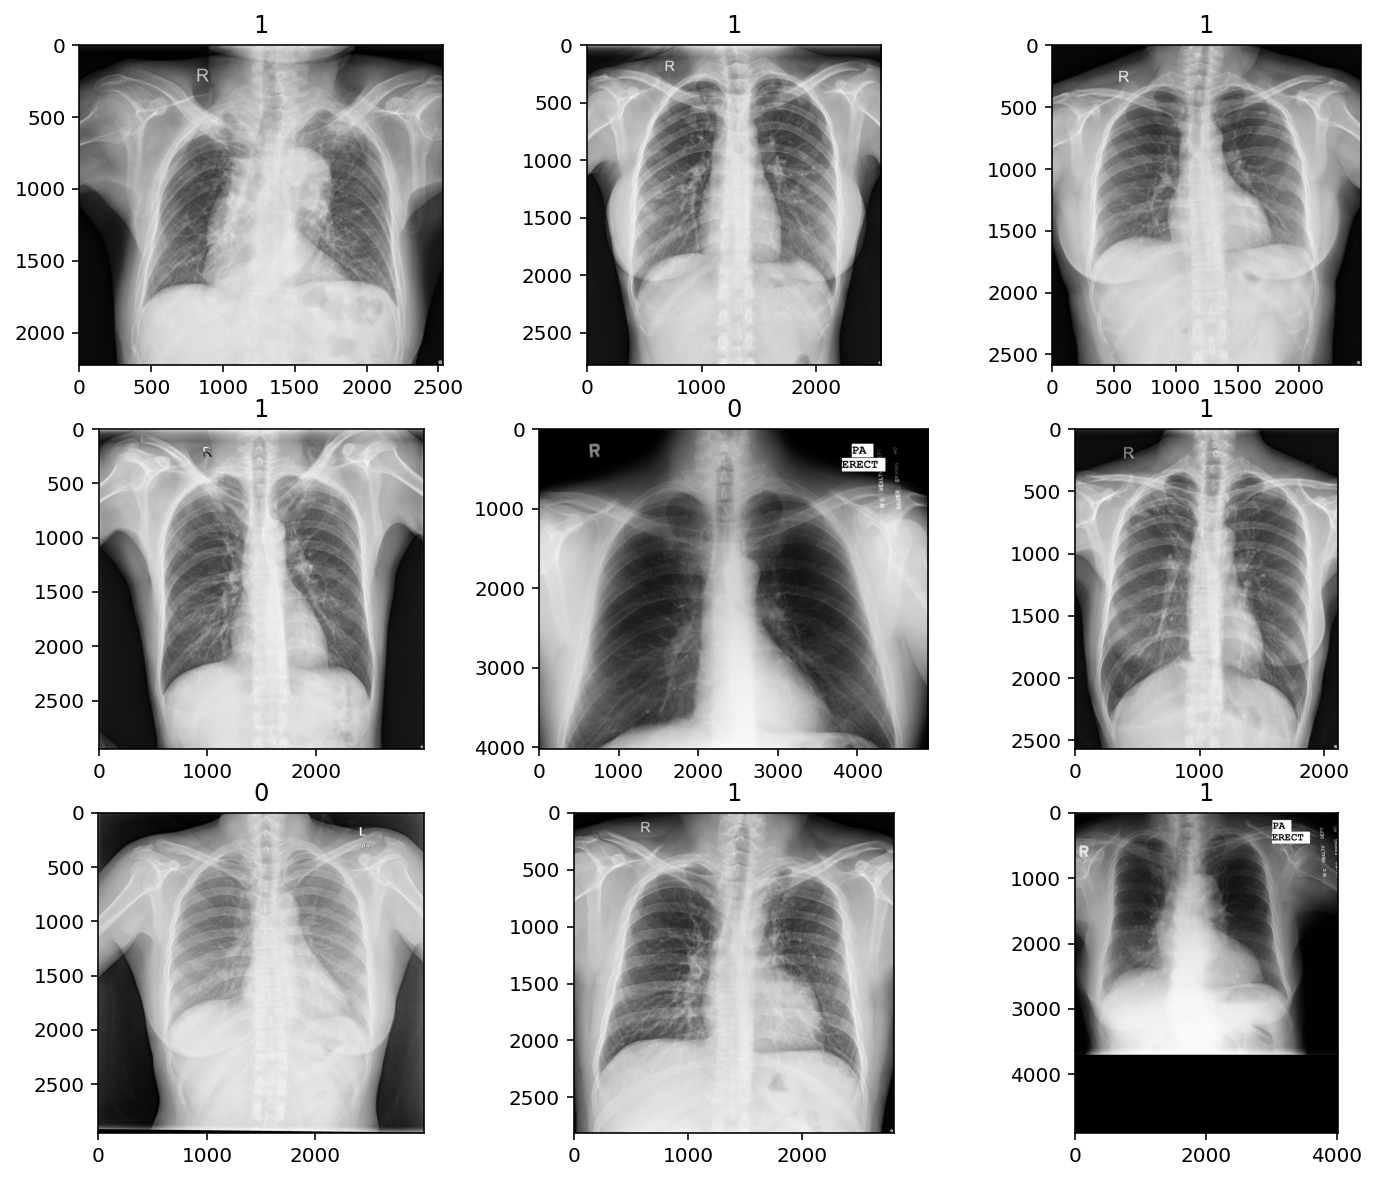

In [8]:
#visualizing random images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

# Creating Custom Dataset

In [9]:
class ImageData(Dataset):
    def __init__(self,data_df,images_dir,transform = None):
        self.annotations = data_df
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.images_dir,self.annotations.iloc[index,2]+".png")
        image = Image.open(img_path).convert('RGB')
        img_label = torch.tensor(self.annotations.iloc[index,1])
        #img_dict = {'image':image,'img_label':img_label}
        
        
        if self.transform:
            image = self.transform(image)
        
        return image,img_label

# Image Transformations

In [10]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [11]:
#defining our data paths
train_data = ImageData(data_df= train,images_dir='data/train',transform = train_transform)
#validation_data = ImageData(data_df= train,images_dir='data/train',transform = test_transform)
test_data = ImageData(data_df= test,images_dir='data/test',transform = test_transform)

In [12]:
val_pct = 0.2
val_size = int(val_pct * len(train_data))
train_size = len(train_data) - val_size
train_data, valid_data = random_split(train_data, [train_size, val_size])

In [13]:
batch_size = 6

dl_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dl_valid = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 96
Number of test batches 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


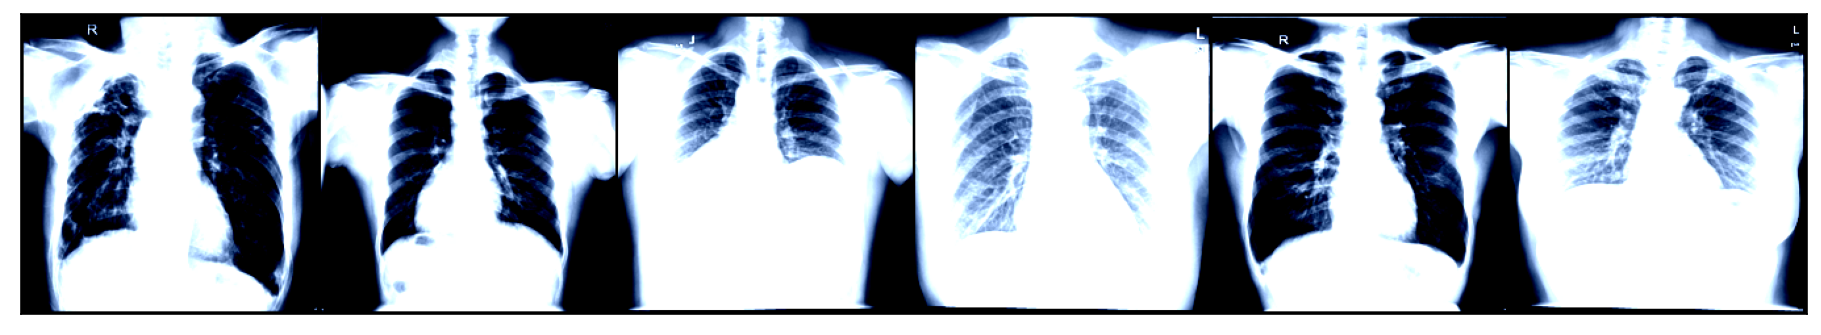

In [14]:
from torchvision.utils import make_grid 
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break
show_batch(dl_train)

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')
        
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
        
device = get_default_device()

In [16]:
dl_train = DeviceDataLoader(dl_train, device)
dl_valid = DeviceDataLoader(dl_valid, device)
dl_test = DeviceDataLoader(dl_test, device)

In [17]:
def accuracy(outputs, labels):
    preds = [1 if pred>0.5 else 0 for pred in outputs]
    preds = torch.as_tensor(preds, dtype=torch.float32, device=device)
    preds = preds.view([torch.tensor(preds.shape).item(), 1])
    return torch.tensor(torch.sum(preds == labels).item() / len(preds), device=device)
    
class BinaryClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        targets = torch.tensor(targets.clone().detach(), dtype=torch.float32, device=device)
        targets = targets.view([torch.tensor(targets.shape).item(),1])
        out = self(images)
        loss = F.binary_cross_entropy(out, targets) 
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        targets = torch.tensor(targets.clone().detach(), dtype=torch.float32, device=device)
        targets = targets.view([torch.tensor(targets.shape).item(),1]) 
        out = self(images)
        loss = F.binary_cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_scores = [x['val_acc'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
            
class TBCnnModel(BinaryClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = torchvision.models.resnet18(pretrained=True)
        n_features = self.network.fc.in_features
        self.network.fc = nn.Linear(n_features, 1)
    
    def forward(self, xb):        
        return torch.sigmoid(self.network(xb))      
        
model = to_device(TBCnnModel(), device)

In [18]:
import torch.nn.functional as F  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    
history = [evaluate(model, dl_valid)]

<ipython-input-17-c1c00276b5bc>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.clone().detach(), dtype=torch.float32, device=device)


In [26]:
from tqdm.notebook import tqdm
num_epochs = 15
max_lr = 3e-5
opt_func = torch.optim.Adam
grad_clip = 0.1
weight_decay = 1e-4

history += fit(num_epochs, max_lr, model, dl_train, dl_valid, weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func)

<ipython-input-17-c1c00276b5bc>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.clone().detach(), dtype=torch.float32, device=device)


<ipython-input-17-c1c00276b5bc>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.clone().detach(), dtype=torch.float32, device=device)


Epoch [0], train_loss: 0.4804, val_loss: 0.4675, val_acc: 0.7889



Epoch [1], train_loss: 0.4678, val_loss: 0.4786, val_acc: 0.7972



Epoch [2], train_loss: 0.4738, val_loss: 0.4668, val_acc: 0.7958



Epoch [3], train_loss: 0.4687, val_loss: 0.4612, val_acc: 0.7778



Epoch [4], train_loss: 0.4532, val_loss: 0.4679, val_acc: 0.7847



Epoch [5], train_loss: 0.4770, val_loss: 0.4637, val_acc: 0.7903



Epoch [6], train_loss: 0.4669, val_loss: 0.4648, val_acc: 0.7903



Epoch [7], train_loss: 0.4562, val_loss: 0.4645, val_acc: 0.7875



Epoch [8], train_loss: 0.4421, val_loss: 0.4446, val_acc: 0.7917



Epoch [9], train_loss: 0.4354, val_loss: 0.4633, val_acc: 0.7958



Epoch [10], train_loss: 0.4416, val_loss: 0.4553, val_acc: 0.7889



Epoch [11], train_loss: 0.4502, val_loss: 0.4603, val_acc: 0.7833



Epoch [12], train_loss: 0.4588, val_loss: 0.4471, val_acc: 0.7819



Epoch [13], train_loss: 0.4267, val_loss: 0.4449, val_acc: 0.7847



Epoch [14], train_loss: 0.4572, val_loss: 0.4509, val_acc: 0.7917


In [27]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return batch_probs
    
test_predictions = predict_dl(dl_test, model)
#test_accuracy = accuracy(test_predictions, test_labels)

IndexError: single positional indexer is out-of-bounds

In [ ]:
test_predictions

# Creating the Model

In [20]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [22]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    #show_images(images, labels, preds)

# Training the Model

In [23]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(dl_test)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 1.0:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [24]:
%%time

train(epochs=7)

Starting training..
Starting epoch 1/7


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Final Results

In [25]:
show_preds()

IndexError: single positional indexer is out-of-bounds